In [177]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**IMPORTING LIBRARIES**

In [1]:
#Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Bidirectional,LSTM, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D,MaxPooling1D
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
!! pip install -q pyyaml h5py
import h5py
from tensorflow.keras import optimizers

**IMPORTING DATASET**

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning/train.csv')

In [3]:
df.head()

,Artist,Song,Genre,Language,Lyrics
0,12 stones,world so cold,Rock,en,"It starts with pain, followed by hate\nFueled ..."
1,12 stones,broken,Rock,en,Freedom!\nAlone again again alone\nPatiently w...
2,12 stones,3 leaf loser,Rock,en,"Biting the hand that feeds you, lying to the v..."
3,12 stones,anthem for the underdog,Rock,en,You say you know just who I am\nBut you can't ...
4,12 stones,adrenaline,Rock,en,My heart is beating faster can't control these...


In [4]:
df.Artist.value_counts().head(10).index

Index(['elvis presley', 'chris brown', 'elvis costello', 'ella fitzgerald',
       'the rolling stones', 'bee gees', 'glee', 'bad religion', 'beyonce',
       'elton john'],
      dtype='object')

In [5]:
artist_list =  df.Artist.value_counts().head(10).index

In [6]:
df = df[df.Artist.isin(artist_list)]

In [7]:
df.shape

(9273, 5)

In [8]:
songs= df['Lyrics']

**DATA CLEANING**

In [9]:
songs={'\n':' '}

In [10]:
df.replace(songs,regex=True,inplace=True)

In [11]:
df.dropna(inplace=True)
df.shape

(9272, 5)

In [12]:
dictionary_length = 1000
input_length = 100

tokenizer = Tokenizer(num_words=dictionary_length)
tokenizer.fit_on_texts(df.Lyrics.values)
post_seq = tokenizer.texts_to_sequences(df.Lyrics.values)
post_seq_padded= sequence.pad_sequences(post_seq, maxlen=input_length)

In [13]:
from sklearn.preprocessing import LabelBinarizer
y = df.Artist.values
label_as_binary = LabelBinarizer()
y_labels = label_as_binary.fit_transform(y)

In [14]:
#Splitting raw text in the input into train and test data for pretrained embeddings
X_train,X_val,y_train,y_val = train_test_split(df['Lyrics'].values,y_labels, test_size=0.3, random_state=23)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val, test_size=0.5, random_state=23)#0.4*50%=20%

In [15]:
#printing shapes of train data
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(6490,)
(1391,)
(1391,)


**LOADING GNEWS-SWIVEL MODEL**

In [16]:
# Recreate the exact same model, including its weights and the optimizer

from keras.models import load_model
import tensorflow_hub as hub
model = load_model('/content/drive/MyDrive/Deep Learning/part1/Model_4.hdf5',custom_objects={'KerasLayer':hub.KerasLayer})

In [17]:
# Show the model architecture

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_10 (Dense)            (None, 16)                816       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 10)                170       
                                                                 
Total params: 48,191,586
Trainable params: 986
Non-trainable params: 48,190,600
_________________________________________________________________


In [18]:
#Compile the model with required optimizer and loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['AUC'])


y_pred= model.predict(X_test)

#Testing the accuracy of model using the test data.
print('\n => Evaluating the model on test data')
results = model.evaluate(X_test, y_test, batch_size=256)
test_loss, test_acc_model1 = results
print("Model AUC on test data: {}% ".format( round(test_acc_model1*100,2)))


 => Evaluating the model on test data
6/6 [==============================] - 2s 31ms/step - loss: 3.3037 - auc: 0.5610
Model AUC on test data: 56.1% 


In [19]:
from sklearn.metrics import roc_auc_score
print(round(roc_auc_score(y_test, y_pred)*100,2))

56.32


**BUILDING MODEL FROM SCRATCH-GNEWS-SWIVEL MODEL**




In [20]:
#Adding the Pre trained word embedding layer to the model
import tensorflow_hub as hub


hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2",input_shape=[], dtype=tf.string)
pre_trained_model = Sequential()
pre_trained_model.add(hub_layer)
pre_trained_model.add(tf.keras.layers.Dense(16, activation='relu'))
pre_trained_model.add(Dropout(0.3))
pre_trained_model.add(tf.keras.layers.Dense(10,activation='softmax'))

pre_trained_model.summary()


#Compile the model with required optimizer and loss function
pre_trained_model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['AUC'])
#Model is fitted to Training data and is validated with validation data
hist_pre_trained = pre_trained_model.fit(X_train, y_train,
          batch_size=256,
          epochs=10,
          validation_data=(X_val, y_val))

#Testing the accuracy of model using the test data.
print('\n => Evaluating the model on test data')
results = pre_trained_model.evaluate(X_test, y_test, batch_size=256)
test_loss, test_acc_new_model = results
print("Model accuracy on test data: {}% ".format( round(test_acc_new_model*100,2)))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 48,191,586
Trainable params: 986
Non-trainable params: 48,190,600
_________________________________________________________________
Epoch 1/10
26/26 [==============================] - 3s 69ms/step - loss: 2.3125 - auc: 0.5495 - val_loss: 2.2746 - val_auc: 0.5771
Epoch 2/10
26/26 [=========================

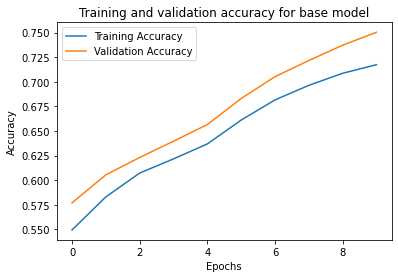

In [21]:
from tensorflow.python.tools import module_util
#Training and validation accuracy graph for base model
plt.plot(hist_pre_trained.history['auc'],label="Training Accuracy")
plt.plot(hist_pre_trained.history['val_auc'],label="Validation Accuracy")
plt.title('Training and validation accuracy for base model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

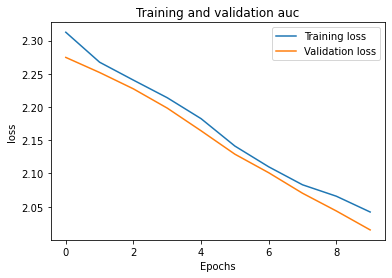

In [22]:
#Training and validation loss plot for gnews model

plt.plot(hist_pre_trained.history['loss'],label="Training loss")
plt.plot(hist_pre_trained.history['val_loss'],label="Validation loss")
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [23]:
#parameters for the model
batch_size = 256
state_size = 8
num_classes = 10
embedding_size=50 

In [24]:
#Splitting raw text in the input into train and test data for pretrained embeddings
X_train1,X_val1,y_train1,y_val1 = train_test_split(post_seq_padded,y_labels, test_size=0.3, random_state=23)
X_val1,X_test1,y_val1,y_test1 = train_test_split(X_val1,y_val1, test_size=0.5, random_state=23)#0.4*50%=20%

In [25]:
#printing shapes of train data
print(X_train1.shape)
print(y_train1.shape)
print(X_val1.shape)
print(y_val1.shape)
print(X_test1.shape)
print(y_test1.shape)
print(dictionary_length)
print(input_length)

(6490, 100)
(6490, 10)
(1391, 100)
(1391, 10)
(1391, 100)
(1391, 10)
1000
100


**LOADING CNN LSTM WITH KERNEL SIZE 5**

In [26]:
from keras.models import load_model
import tensorflow_hub as hub
cnn_lstm_model = load_model('/content/drive/MyDrive/Deep Learning/part1/Model_8.hdf5',custom_objects={'KerasLayer':hub.KerasLayer})

In [27]:
cnn_lstm_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 50)           50000     
                                                                 
 conv1d_8 (Conv1D)           (None, 98, 50)            7550      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 49, 50)           0         
 1D)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 25)                7600      
                                                                 
 dense_29 (Dense)            (None, 10)                260       
                                                                 
Total params: 65,410
Trainable params: 65,410
Non-trainable params: 0
_________________________________________________

In [28]:
cnn_lstm_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['AUC'])

#Fitting the model to the test data and validating with the validation data
#hist_cnn_lstm = cnn_lstm_model.fit(X_train1, y_train1, batch_size=256, epochs=1, validation_data=(X_val1, y_val1))

#Testing the accuracy of model using the test data.
print('\n => Evaluate on test data')
results = cnn_lstm_model.evaluate(X_test1, y_test1, batch_size=256)
test_loss, test_acc_models = results
print("Model accuracy is: {}% ".format( round(test_acc_models*100,2)))


 => Evaluate on test data
6/6 [==============================] - 1s 35ms/step - loss: 3.6735 - auc: 0.5215
Model accuracy is: 52.15% 


**BUILDING MODEL FROM SCRATCH-CNN LSTM WITH KERNEL SIZE 5** 

In [29]:
#CNN and LSTM
pool_size=2
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Embedding(dictionary_length,embedding_size,input_length=input_length))
cnn_lstm_model.add(Conv1D(50, 3, padding='valid',activation='relu'))
#cnn_lstm_model.add(GlobalAveragePooling1D())
cnn_lstm_model.add(MaxPooling1D(pool_size=pool_size))
cnn_lstm_model.add(LSTM(25,dropout=0.2, recurrent_dropout=0.2))
#cnn_lstm_model.add(Dropout(0.2))
#cnn_lstm_model.add(Dense(25, activation='relu'))
cnn_lstm_model.add(Dense(10, activation='softmax'))


cnn_lstm_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['AUC'])

cnn_lstm_model.summary()


#Fitting the model to the test data and validating with the validation data
hist_cnn_lstm = cnn_lstm_model.fit(X_train1, y_train1, batch_size=batch_size, epochs=10, validation_data=(X_val1, y_val1))

#Testing the accuracy of model using the test data.
print('\n => Evaluate on test data')
results = cnn_lstm_model.evaluate(X_test1, y_test1, batch_size=batch_size)
test_loss, test_acc_model2 = results
print("Model accuracy is: {}% ".format( round(test_acc_model2*100,2)))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           50000     
                                                                 
 conv1d (Conv1D)             (None, 98, 50)            7550      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 50)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 25)                7600      
                                                                 
 dense_2 (Dense)             (None, 10)                260       
                                                                 
Total params: 65,410
Trainable params: 65,410
Non-trainable params: 0
__________________________________________________

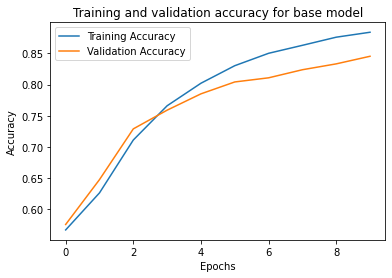

In [30]:
from tensorflow.python.tools import module_util
#Training and validation accuracy graph for base model
plt.plot(hist_cnn_lstm.history['auc'],label="Training Accuracy")
plt.plot(hist_cnn_lstm.history['val_auc'],label="Validation Accuracy")
plt.title('Training and validation accuracy for base model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

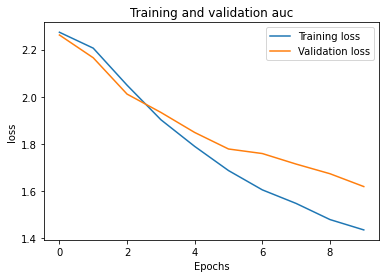

In [31]:
#Training and validation loss plot for gnews model

plt.plot(hist_cnn_lstm.history['loss'],label="Training loss")
plt.plot(hist_cnn_lstm.history['val_loss'],label="Validation loss")
plt.title('Training and validation auc')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

In [32]:
from prettytable import PrettyTable

x = PrettyTable()
print('\n')
print("Deatiled Performance of the all models")
x.field_names = ["Model", "AUC"]

x.add_row(["PRE Trained Embedding From Scratch", round(test_acc_new_model,3)])
x.add_row(["Transfer Learning from model 4", round(test_acc_model1,3)])
x.add_row(["Transfer Learning from model 8", round(test_acc_models,3)])
x.add_row(["CNN_LSTM from Scratch", round(test_acc_model2,3)])

print(x)
print('\n')



Deatiled Performance of the all models
+------------------------------------+-------+
|               Model                |  AUC  |
+------------------------------------+-------+
| PRE Trained Embedding From Scratch | 0.757 |
|   Transfer Learning from model 4   | 0.561 |
|   Transfer Learning from model 8   | 0.522 |
|       CNN_LSTM from Scratch        | 0.854 |
+------------------------------------+-------+




In [33]:
X_test[0]

"warst du schon mal in der wuste? schon mal den tod gesehen? hunderttausend kinder sterben fur brot und die zahlen lugen nicht es ist die krankheit der menschen doch wir tun was wir wollen wir denken wie es uns gefallt hast du die erfahrung gemacht? hast du die plage gesehen? leute machen kinder einfach nur um zu fliehen im land des wettbewerbs ist kein mitleid mehr da und wir vergessen die armen wir machen weiter und weiter weiter und weiter dies ist nur ein punk rock song fur die die sehen dass es so nicht weitergeht wie ameisen im haufen sind wir programmiert aber es gibt immer mehr von dieser verfickten art aber dies ist nur ein punk rock song hast du schon mal nicht weitergewusst? schon mal in der scheisse gesteckt? die parteitagungen und die realpolitik die gesichter wechseln das gelaber bleibt alles wird geschluckt und so wird sich nichts andern dies ist nur ein punk rock song fur die die sehen dass es so nicht weitergeht wie fliessbandarbeiter tun wir unsere pflicht und es gibt

In [34]:
y_pred[:5,:].round(2)

array([[0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.52, 0.13, 0.  , 0.32],
       [0.02, 0.  , 0.05, 0.  , 0.02, 0.13, 0.01, 0.26, 0.01, 0.49],
       [0.01, 0.01, 0.06, 0.  , 0.03, 0.08, 0.02, 0.24, 0.01, 0.55],
       [0.  , 0.01, 0.02, 0.01, 0.03, 0.03, 0.09, 0.38, 0.01, 0.41],
       [0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.03, 0.82, 0.01, 0.11]],
      dtype=float32)

ARTIST PREDICTION USING BEST PERFORMING MODEL

In [41]:
Predictions =pd.DataFrame(X_test)  
Predictions['Artist']= label_as_binary.inverse_transform(y_pred.round())

In [42]:
Predictions

,0,Artist
0,warst du schon mal in der wuste? schon mal den...,elvis costello
1,"Just hear those sleigh bells jingling, ring-ti...",bad religion
2,Look out my window.I can see tomorrow. Just a ...,the rolling stones
3,(M Jagger/K Richards) You know that we do take...,bad religion
4,Said I'm all up in my feelings Cover them on t...,elvis presley
...,...,...
1386,I know your eyes in the morning sun I feel you...,bad religion
1387,"Oh me oh my Get out of your 1950's fantasy, Yo...",bad religion
1388,"Sleep, my little Jesus On Thy bed of hay While...",bad religion
1389,There are lots of girls in the mountains And t...,the rolling stones
